### Decision Tree

In [1]:
import optuna
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 불러오기

per = 1

train_data = pd.read_csv("/home/watercar99/project/MIMIC-III/Data Extract/Tabular Data/FINAL Data Extract/DATA/train_test_data/Final_train_data("+str(per)+"%)_down.csv")
test_data = pd.read_csv("/home/watercar99/project/MIMIC-III/Data Extract/Tabular Data/FINAL Data Extract/DATA/train_test_data/Final_test_data("+str(per)+"%)_down.csv")

train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "ETHNICITY", "TLOS", "LOS"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA",  "ETHNICITY", "TLOS", "LOS"], axis=1, inplace=True)

# train 데이터의 모드(Mode) 값 및 중앙값(Median) 계산
mode_values = train_data[['GENDER', 'Ventilator', 'Anisocytosis', 'Macrocytes', 'Poikilocytosis', 'Bacteria', 'Bilirubin', 'Urine Appearance', 'Urine Color']].mode().iloc[0]
median_values = train_data.drop(columns=['GENDER', 'Ventilator', 'Anisocytosis', 'Macrocytes', 'Poikilocytosis', 'Bacteria', 'Bilirubin', 'Urine Appearance', 'Urine Color']).median()

# train 데이터와 test 데이터의 결측치를 채움
train_data[['GENDER', 'Ventilator', 'Anisocytosis', 'Macrocytes', 'Poikilocytosis', 'Bacteria', 'Bilirubin', 'Urine Appearance', 'Urine Color']] = train_data[['GENDER', 'Ventilator', 'Anisocytosis', 'Macrocytes', 'Poikilocytosis', 'Bacteria', 'Bilirubin', 'Urine Appearance', 'Urine Color']].fillna(mode_values)
test_data[['GENDER', 'Ventilator', 'Anisocytosis', 'Macrocytes', 'Poikilocytosis', 'Bacteria', 'Bilirubin', 'Urine Appearance', 'Urine Color']] = test_data[['GENDER', 'Ventilator', 'Anisocytosis', 'Macrocytes', 'Poikilocytosis', 'Bacteria', 'Bilirubin', 'Urine Appearance', 'Urine Color']].fillna(mode_values)

# 나머지 칼럼들의 결측치를 중앙값으로 채움
train_data = train_data.fillna(median_values)
test_data = test_data.fillna(median_values)

                
train_data = pd.get_dummies(train_data, columns=['GENDER', 'Ventilator', 'Anisocytosis', 'Macrocytes', 'Poikilocytosis', 'Bacteria', 'Bilirubin', 'Urine Appearance', 'Urine Color'])
test_data = pd.get_dummies(test_data, columns=['GENDER', 'Ventilator', 'Anisocytosis', 'Macrocytes', 'Poikilocytosis', 'Bacteria', 'Bilirubin', 'Urine Appearance', 'Urine Color'])

# 결측치가 있는 칼럼을 확인하고 제거합니다.
train_data = train_data.dropna(axis=1)
test_data = test_data.dropna(axis=1)

In [3]:
# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0

# Features와 Target 설정
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)

print("train shape\n",X_train.shape,"\n")
print("train shape\n",X_test.shape,"\n")

target = "y"
features = [f for f in train_data.columns if f not in [target]]

print("train value\n",train_data['y'].value_counts())
print("test value\n",test_data['y'].value_counts())

train shape
 (978, 98) 

train shape
 (457, 98) 

train value
 1    489
0    489
Name: y, dtype: int64
test value
 0    341
1    116
Name: y, dtype: int64


In [4]:
# Objective 함수 정의
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 2, 10)
    min_samples_split = trial.suggest_float("min_samples_split", 0.1, 1.0)
    min_samples_leaf = trial.suggest_float("min_samples_leaf", 0.1, 0.5)
    
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Cross Validation을 활용한 평가 지표 계산
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
    return scores.mean()

In [5]:
from sklearn.metrics import roc_auc_score

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
y_pred_list = []
model_list = []
auroc_list = []

for _ in range(10):

    # Optuna를 활용한 Hyperparameter tuning
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30, show_progress_bar=True)

    # 최적의 Hyperparameter로 모델 학습
    best_params = study.best_params
    best_model = DecisionTreeClassifier(
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
        random_state=42
    )
    best_model.fit(X_train, y_train)
    
    # Test 데이터로 모델 평가
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(test_data['y'], y_pred)
    precision = precision_score(test_data['y'], y_pred)
    recall = recall_score(test_data['y'], y_pred)
    f1 = f1_score(test_data['y'], y_pred)
    auroc = roc_auc_score(test_data['y'], y_pred)

    rounded_accuracy = round(accuracy * 100, 2)
    rounded_precision = round(precision * 100, 2)
    rounded_recall = round(recall * 100, 2)
    rounded_f1 = round(f1 * 100, 2)
    rounded_auroc = round(auroc * 100, 2)
    
    accuracy_list.append(rounded_accuracy)
    precision_list.append(rounded_precision)
    recall_list.append(rounded_recall)
    f1_list.append(rounded_f1)
    y_pred_list.append(y_pred)
    auroc_list.append(rounded_auroc)
    
    print("Test Accuracy:", rounded_accuracy)
    print("Precision:", rounded_precision)
    print("Recall:", rounded_recall)
    print("F1-score:", rounded_f1)
    print("AUROC:", rounded_auroc)

[I 2023-10-07 02:05:21,467] A new study created in memory with name: no-name-a64fa590-8ff8-420f-9cb3-c1efa1d61c24


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-07 02:05:21,724] Trial 0 finished with value: 0.6058397976143246 and parameters: {'max_depth': 5, 'min_samples_split': 0.10032442703941635, 'min_samples_leaf': 0.19632994764607148}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:21,855] Trial 1 finished with value: 0.5950298423260723 and parameters: {'max_depth': 9, 'min_samples_split': 0.23802231660165774, 'min_samples_leaf': 0.3469664238094601}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:21,932] Trial 2 finished with value: 0.6058397976143246 and parameters: {'max_depth': 3, 'min_samples_split': 0.4932367200668143, 'min_samples_leaf': 0.17855259170815307}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:21,993] Trial 3 finished with value: 0.5950298423260723 and parameters: {'max_depth': 2, 'min_samples_split': 0.2982743743896199, 'min_samples_leaf': 0.4414279673522721}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:22,061] Trial 4 fini

[I 2023-10-07 02:05:24,108] A new study created in memory with name: no-name-57c8c050-ac87-4076-8c74-88921eacd6b9


[I 2023-10-07 02:05:24,017] Trial 28 finished with value: 0.5950298423260723 and parameters: {'max_depth': 5, 'min_samples_split': 0.8432838310920834, 'min_samples_leaf': 0.23378664379926833}. Best is trial 11 with value: 0.6198980742247616.
[I 2023-10-07 02:05:24,084] Trial 29 finished with value: 0.5950298423260723 and parameters: {'max_depth': 10, 'min_samples_split': 0.4527617329702335, 'min_samples_leaf': 0.35638432615193705}. Best is trial 11 with value: 0.6198980742247616.
Test Accuracy: 47.26
Precision: 28.52
Recall: 71.55
F1-score: 40.79
AUROC: 55.28


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-07 02:05:24,248] Trial 0 finished with value: 0.5950298423260723 and parameters: {'max_depth': 4, 'min_samples_split': 0.5910543158794952, 'min_samples_leaf': 0.45084599944715165}. Best is trial 0 with value: 0.5950298423260723.
[I 2023-10-07 02:05:24,327] Trial 1 finished with value: 0.5950298423260723 and parameters: {'max_depth': 3, 'min_samples_split': 0.8321138992580416, 'min_samples_leaf': 0.22637760328322132}. Best is trial 0 with value: 0.5950298423260723.
[I 2023-10-07 02:05:24,384] Trial 2 finished with value: 0.5950298423260723 and parameters: {'max_depth': 9, 'min_samples_split': 0.5392943924959961, 'min_samples_leaf': 0.3811837943273584}. Best is trial 0 with value: 0.5950298423260723.
[I 2023-10-07 02:05:24,478] Trial 3 finished with value: 0.5950298423260723 and parameters: {'max_depth': 8, 'min_samples_split': 0.5592560736334541, 'min_samples_leaf': 0.421544096339983}. Best is trial 0 with value: 0.5950298423260723.
[I 2023-10-07 02:05:24,533] Trial 4 finishe

[I 2023-10-07 02:05:26,518] A new study created in memory with name: no-name-607d23ee-15f7-4069-b453-ea050a79a9ef


[I 2023-10-07 02:05:26,372] Trial 27 finished with value: 0.5950298423260723 and parameters: {'max_depth': 9, 'min_samples_split': 0.2962146702794387, 'min_samples_leaf': 0.374002312908153}. Best is trial 14 with value: 0.6058648940788601.
[I 2023-10-07 02:05:26,452] Trial 28 finished with value: 0.6058397976143246 and parameters: {'max_depth': 7, 'min_samples_split': 0.16493950382873762, 'min_samples_leaf': 0.23714903761445735}. Best is trial 14 with value: 0.6058648940788601.
[I 2023-10-07 02:05:26,504] Trial 29 finished with value: 0.6058648940788601 and parameters: {'max_depth': 5, 'min_samples_split': 0.24944435345728702, 'min_samples_leaf': 0.26032522305362416}. Best is trial 14 with value: 0.6058648940788601.
Test Accuracy: 53.39
Precision: 26.34
Recall: 46.55
F1-score: 33.64
AUROC: 51.14


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-07 02:05:26,599] Trial 0 finished with value: 0.6007109292795331 and parameters: {'max_depth': 7, 'min_samples_split': 0.7076255767416231, 'min_samples_leaf': 0.48888792451945384}. Best is trial 0 with value: 0.6007109292795331.
[I 2023-10-07 02:05:26,653] Trial 1 finished with value: 0.5950298423260723 and parameters: {'max_depth': 4, 'min_samples_split': 0.909835524153842, 'min_samples_leaf': 0.3865902744988562}. Best is trial 0 with value: 0.6007109292795331.
[I 2023-10-07 02:05:26,713] Trial 2 finished with value: 0.5950298423260723 and parameters: {'max_depth': 6, 'min_samples_split': 0.30589787702696225, 'min_samples_leaf': 0.41143382029702324}. Best is trial 0 with value: 0.6007109292795331.
[I 2023-10-07 02:05:26,776] Trial 3 finished with value: 0.6198980742247616 and parameters: {'max_depth': 4, 'min_samples_split': 0.511063515168949, 'min_samples_leaf': 0.11362416815266863}. Best is trial 3 with value: 0.6198980742247616.
[I 2023-10-07 02:05:26,835] Trial 4 finish

[I 2023-10-07 02:05:28,946] A new study created in memory with name: no-name-f1e86472-2ed3-4083-952f-ebe3e504a9de


[I 2023-10-07 02:05:28,780] Trial 28 finished with value: 0.5606899383511363 and parameters: {'max_depth': 3, 'min_samples_split': 0.32858731449673084, 'min_samples_leaf': 0.10203221251449955}. Best is trial 3 with value: 0.6198980742247616.
[I 2023-10-07 02:05:28,901] Trial 29 finished with value: 0.5950298423260723 and parameters: {'max_depth': 2, 'min_samples_split': 0.6574909347914942, 'min_samples_leaf': 0.15133460513199531}. Best is trial 3 with value: 0.6198980742247616.
Test Accuracy: 47.26
Precision: 28.52
Recall: 71.55
F1-score: 40.79
AUROC: 55.28


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-07 02:05:29,081] Trial 0 finished with value: 0.5808610046228436 and parameters: {'max_depth': 9, 'min_samples_split': 0.2195519604699682, 'min_samples_leaf': 0.1417107202323313}. Best is trial 0 with value: 0.5808610046228436.
[I 2023-10-07 02:05:29,146] Trial 1 finished with value: 0.5950298423260723 and parameters: {'max_depth': 4, 'min_samples_split': 0.8466687003344906, 'min_samples_leaf': 0.32010380682249695}. Best is trial 1 with value: 0.5950298423260723.
[I 2023-10-07 02:05:29,203] Trial 2 finished with value: 0.5950298423260723 and parameters: {'max_depth': 10, 'min_samples_split': 0.9835851856828268, 'min_samples_leaf': 0.34162224309766104}. Best is trial 1 with value: 0.5950298423260723.
[I 2023-10-07 02:05:29,274] Trial 3 finished with value: 0.5950298423260723 and parameters: {'max_depth': 7, 'min_samples_split': 0.8591084523593565, 'min_samples_leaf': 0.27929498186181717}. Best is trial 1 with value: 0.5950298423260723.
[I 2023-10-07 02:05:29,335] Trial 4 fini

[I 2023-10-07 02:05:31,602] A new study created in memory with name: no-name-b666f583-a7ab-41ce-9688-a2dadef15c9e


[I 2023-10-07 02:05:31,582] Trial 29 finished with value: 0.5950298423260723 and parameters: {'max_depth': 10, 'min_samples_split': 0.1799043380374899, 'min_samples_leaf': 0.3670001763741059}. Best is trial 21 with value: 0.6058648940788601.
Test Accuracy: 53.39
Precision: 26.34
Recall: 46.55
F1-score: 33.64
AUROC: 51.14


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-07 02:05:31,696] Trial 0 finished with value: 0.6058397976143246 and parameters: {'max_depth': 5, 'min_samples_split': 0.28799065435459786, 'min_samples_leaf': 0.24478687834609475}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:31,755] Trial 1 finished with value: 0.5950298423260723 and parameters: {'max_depth': 7, 'min_samples_split': 0.8279855354034336, 'min_samples_leaf': 0.3835837902592576}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:31,826] Trial 2 finished with value: 0.5950298423260723 and parameters: {'max_depth': 9, 'min_samples_split': 0.6551979573274187, 'min_samples_leaf': 0.18783276220929093}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:31,922] Trial 3 finished with value: 0.5950298423260723 and parameters: {'max_depth': 10, 'min_samples_split': 0.9942083108091525, 'min_samples_leaf': 0.4621224614292313}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:31,984] Trial 4 fini

[I 2023-10-07 02:05:33,904] A new study created in memory with name: no-name-1174233b-1d29-48ed-aaa1-2a8343ad7d45


[I 2023-10-07 02:05:33,801] Trial 28 finished with value: 0.5950298423260723 and parameters: {'max_depth': 4, 'min_samples_split': 0.49943484692497553, 'min_samples_leaf': 0.3013356765048709}. Best is trial 23 with value: 0.6058648940788601.
[I 2023-10-07 02:05:33,872] Trial 29 finished with value: 0.5950298423260723 and parameters: {'max_depth': 5, 'min_samples_split': 0.6536676068438781, 'min_samples_leaf': 0.35276764635124824}. Best is trial 23 with value: 0.6058648940788601.
Test Accuracy: 53.39
Precision: 26.34
Recall: 46.55
F1-score: 33.64
AUROC: 51.14


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-07 02:05:34,018] Trial 0 finished with value: 0.6058648940788601 and parameters: {'max_depth': 6, 'min_samples_split': 0.21357686044281687, 'min_samples_leaf': 0.2592786932567038}. Best is trial 0 with value: 0.6058648940788601.
[I 2023-10-07 02:05:34,083] Trial 1 finished with value: 0.5950298423260723 and parameters: {'max_depth': 8, 'min_samples_split': 0.4006598243028213, 'min_samples_leaf': 0.46502103116434346}. Best is trial 0 with value: 0.6058648940788601.
[I 2023-10-07 02:05:34,141] Trial 2 finished with value: 0.5950298423260723 and parameters: {'max_depth': 5, 'min_samples_split': 0.20008845444072126, 'min_samples_leaf': 0.3851807642157764}. Best is trial 0 with value: 0.6058648940788601.
[I 2023-10-07 02:05:34,212] Trial 3 finished with value: 0.5950298423260723 and parameters: {'max_depth': 5, 'min_samples_split': 0.8305803793600213, 'min_samples_leaf': 0.16287209097208347}. Best is trial 0 with value: 0.6058648940788601.
[I 2023-10-07 02:05:34,273] Trial 4 fini

[I 2023-10-07 02:05:36,412] A new study created in memory with name: no-name-81560f2e-a02f-480b-9421-7c5c3fe1f8d2


[I 2023-10-07 02:05:36,290] Trial 28 finished with value: 0.5950298423260723 and parameters: {'max_depth': 5, 'min_samples_split': 0.25425396253226606, 'min_samples_leaf': 0.31016578555918817}. Best is trial 0 with value: 0.6058648940788601.
[I 2023-10-07 02:05:36,382] Trial 29 finished with value: 0.6058397976143246 and parameters: {'max_depth': 8, 'min_samples_split': 0.3939775707417177, 'min_samples_leaf': 0.2091308558118808}. Best is trial 0 with value: 0.6058648940788601.
Test Accuracy: 53.39
Precision: 26.34
Recall: 46.55
F1-score: 33.64
AUROC: 51.14


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-07 02:05:36,533] Trial 0 finished with value: 0.6058397976143246 and parameters: {'max_depth': 3, 'min_samples_split': 0.14173569688995707, 'min_samples_leaf': 0.20024329418094014}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:36,589] Trial 1 finished with value: 0.5950298423260723 and parameters: {'max_depth': 10, 'min_samples_split': 0.8555512198499714, 'min_samples_leaf': 0.15239359903849303}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:36,645] Trial 2 finished with value: 0.5950298423260723 and parameters: {'max_depth': 2, 'min_samples_split': 0.8239215572430079, 'min_samples_leaf': 0.391172378270607}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:36,776] Trial 3 finished with value: 0.6058397976143246 and parameters: {'max_depth': 8, 'min_samples_split': 0.5196869037037509, 'min_samples_leaf': 0.23218254676212693}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:36,898] Trial 4 fini

[I 2023-10-07 02:05:39,705] A new study created in memory with name: no-name-c3ab223e-906f-4b5e-9e60-f6ec7a937e13


[I 2023-10-07 02:05:39,672] Trial 29 finished with value: 0.5808610046228436 and parameters: {'max_depth': 4, 'min_samples_split': 0.11087975500695513, 'min_samples_leaf': 0.14129529566894589}. Best is trial 0 with value: 0.6058397976143246.
Test Accuracy: 53.39
Precision: 26.34
Recall: 46.55
F1-score: 33.64
AUROC: 51.14


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-07 02:05:39,918] Trial 0 finished with value: 0.6058397976143246 and parameters: {'max_depth': 7, 'min_samples_split': 0.23806920592667566, 'min_samples_leaf': 0.23103832960346887}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:40,014] Trial 1 finished with value: 0.5950298423260723 and parameters: {'max_depth': 7, 'min_samples_split': 0.10891373444420879, 'min_samples_leaf': 0.39265925493209397}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:40,128] Trial 2 finished with value: 0.5806864841674291 and parameters: {'max_depth': 7, 'min_samples_split': 0.3857274337038529, 'min_samples_leaf': 0.1293801422869535}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:40,190] Trial 3 finished with value: 0.5950298423260723 and parameters: {'max_depth': 6, 'min_samples_split': 0.1491293765873656, 'min_samples_leaf': 0.35810859028645325}. Best is trial 0 with value: 0.6058397976143246.
[I 2023-10-07 02:05:40,247] Trial 4 fin

[I 2023-10-07 02:05:42,771] A new study created in memory with name: no-name-aebd98f1-f531-4397-b074-b0bd26dde255


[I 2023-10-07 02:05:42,743] Trial 29 finished with value: 0.6058648940788601 and parameters: {'max_depth': 2, 'min_samples_split': 0.30887938798876347, 'min_samples_leaf': 0.26065925202048623}. Best is trial 14 with value: 0.6058648940788601.
Test Accuracy: 53.39
Precision: 26.34
Recall: 46.55
F1-score: 33.64
AUROC: 51.14


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-07 02:05:42,878] Trial 0 finished with value: 0.5950298423260723 and parameters: {'max_depth': 2, 'min_samples_split': 0.7690422549746011, 'min_samples_leaf': 0.2887816838769661}. Best is trial 0 with value: 0.5950298423260723.
[I 2023-10-07 02:05:42,971] Trial 1 finished with value: 0.5808610046228436 and parameters: {'max_depth': 4, 'min_samples_split': 0.25343452390255106, 'min_samples_leaf': 0.137328741044326}. Best is trial 0 with value: 0.5950298423260723.
[I 2023-10-07 02:05:43,028] Trial 2 finished with value: 0.5950298423260723 and parameters: {'max_depth': 6, 'min_samples_split': 0.7589123586715392, 'min_samples_leaf': 0.3879691423308458}. Best is trial 0 with value: 0.5950298423260723.
[I 2023-10-07 02:05:43,103] Trial 3 finished with value: 0.5950298423260723 and parameters: {'max_depth': 10, 'min_samples_split': 0.15373722293754355, 'min_samples_leaf': 0.40185967568344416}. Best is trial 0 with value: 0.5950298423260723.
[I 2023-10-07 02:05:43,163] Trial 4 finis

[I 2023-10-07 02:05:45,156] A new study created in memory with name: no-name-7ff2c710-fbca-4f80-a2a4-12d9e85485dc


[I 2023-10-07 02:05:44,959] Trial 27 finished with value: 0.6041780106029389 and parameters: {'max_depth': 5, 'min_samples_split': 0.938997605120344, 'min_samples_leaf': 0.4750517079681398}. Best is trial 13 with value: 0.6041780106029389.
[I 2023-10-07 02:05:45,031] Trial 28 finished with value: 0.5950298423260723 and parameters: {'max_depth': 7, 'min_samples_split': 0.8266309753836378, 'min_samples_leaf': 0.4220094577616186}. Best is trial 13 with value: 0.6041780106029389.
[I 2023-10-07 02:05:45,128] Trial 29 finished with value: 0.5950298423260723 and parameters: {'max_depth': 2, 'min_samples_split': 0.6435404623246025, 'min_samples_leaf': 0.32300532957257466}. Best is trial 13 with value: 0.6041780106029389.
Test Accuracy: 53.39
Precision: 26.34
Recall: 46.55
F1-score: 33.64
AUROC: 51.14


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-07 02:05:45,261] Trial 0 finished with value: 0.5950298423260723 and parameters: {'max_depth': 7, 'min_samples_split': 0.6099537023167259, 'min_samples_leaf': 0.2941932023941388}. Best is trial 0 with value: 0.5950298423260723.
[I 2023-10-07 02:05:45,326] Trial 1 finished with value: 0.5950298423260723 and parameters: {'max_depth': 2, 'min_samples_split': 0.30710330272644626, 'min_samples_leaf': 0.43148158492845534}. Best is trial 0 with value: 0.5950298423260723.
[I 2023-10-07 02:05:45,384] Trial 2 finished with value: 0.5950298423260723 and parameters: {'max_depth': 3, 'min_samples_split': 0.73748116518959, 'min_samples_leaf': 0.22428235237734717}. Best is trial 0 with value: 0.5950298423260723.
[I 2023-10-07 02:05:45,456] Trial 3 finished with value: 0.5950298423260723 and parameters: {'max_depth': 9, 'min_samples_split': 0.7627083310694185, 'min_samples_leaf': 0.29578338391598613}. Best is trial 0 with value: 0.5950298423260723.
[I 2023-10-07 02:05:45,516] Trial 4 finish

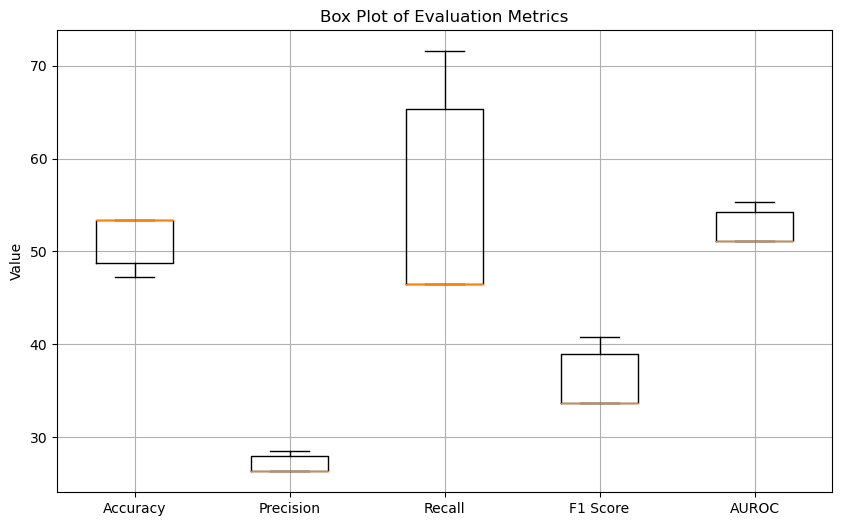

In [6]:
import matplotlib.pyplot as plt

# 박스 플롯 그리기
data = [accuracy_list, precision_list, recall_list, f1_list, auroc_list]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score','AUROC']

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.title('Box Plot of Evaluation Metrics')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [7]:
data = {
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list,
    'AUROC':auroc_list,
    'Predictions': y_pred_list
    
}

# 딕셔너리를 DataFrame으로 변환
df = pd.DataFrame(data)
df

,Accuracy,Precision,Recall,F1 Score,AUROC,Predictions
0,47.26,28.52,71.55,40.79,55.28,"[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, ..."
1,53.39,26.34,46.55,33.64,51.14,"[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ..."
2,47.26,28.52,71.55,40.79,55.28,"[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, ..."
3,53.39,26.34,46.55,33.64,51.14,"[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ..."
4,53.39,26.34,46.55,33.64,51.14,"[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ..."
5,53.39,26.34,46.55,33.64,51.14,"[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ..."
6,53.39,26.34,46.55,33.64,51.14,"[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ..."
7,53.39,26.34,46.55,33.64,51.14,"[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ..."
8,53.39,26.34,46.55,33.64,51.14,"[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ..."
9,47.26,28.52,71.55,40.79,55.28,"[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, ..."


### result

In [8]:
df.to_csv('~/project/MIMIC-III/Model/Output/DT/DT_'+str(per)+'%_output.csv', index=False)

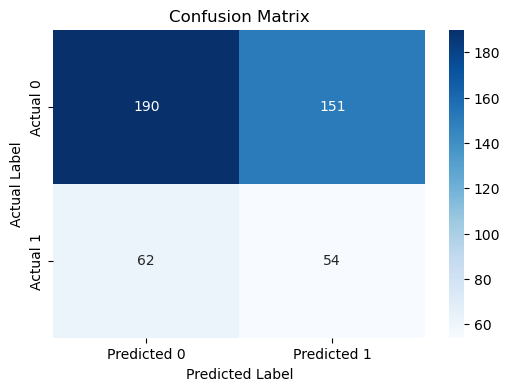

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.39      0.52       341
           1       0.29      0.72      0.41       116

    accuracy                           0.47       457
   macro avg       0.54      0.55      0.47       457
weighted avg       0.67      0.47      0.50       457



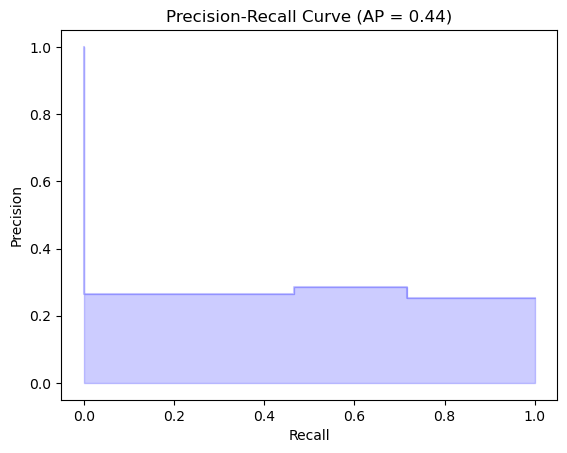

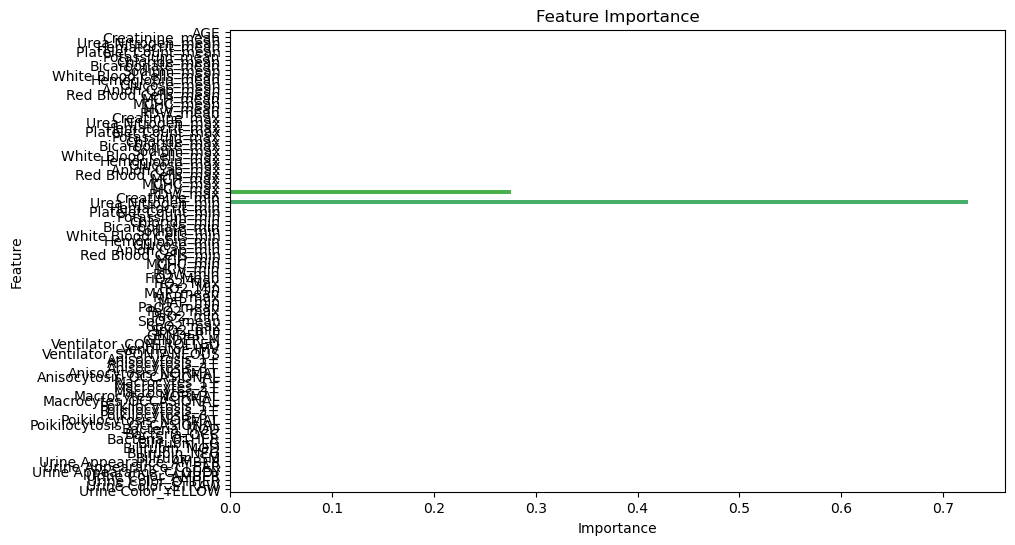

In [10]:
# 그리고 싶은 confusion matrix index
idx = 1 

cm = confusion_matrix(test_data['y'], y_pred_list[idx])


# Confusion Matrix 시각화
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# Classification Report 출력
print("Classification Report:")
print(classification_report(test_data['y'], y_pred))

# Precision-Recall Curve 계산 및 시각화
precision, recall, _ = precision_recall_curve(test_data['y'], best_model.predict_proba(X_test)[:, 1])
average_precision = auc(recall, precision)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.show()

# Feature Importance 계산
feature_importance = best_model.feature_importances_

# Feature Importance 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()